In [21]:
# Basic manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing PyTorch functionalities
import torch
import torch.nn as nn
import torch.nn.functional as activation
import torch.optim as optim
from torch.utils.data import Dataset
import hiddenlayer as hl

# To get the metrics for evaluation\n",
from sklearn.metrics import f1_score,precision_recall_curve,ConfusionMatrixDisplay,confusion_matrix,roc_curve,classification_report

# More utilities\n",
from PIL import Image
from glob import glob
import gc
torch.cuda.empty_cache()
gc.collect()
# Dataset Locations

# Training Set : 60% (900 Images)
trainLocation="./full_dataset/Train"

# Validation Set : 20% (300 Images)\n",
validationLocation="./full_dataset/Val"

# Testing Set : 20% (300 Images)
testLocation="./full_dataset/Test"


In [22]:
"""
Save Model :
torch.save(baseLine.state_dict(),PATH)
"""


'\nSave Model :\ntorch.save(baseLine.state_dict(),PATH)\n'

In [23]:
# Cuda Initializer
if torch.cuda.is_available():
    device=torch.device("cuda:0")
else:
    device=torch.device("cpu")

In [24]:
# Establishing the Dataset class

class TumorDataset(Dataset):
    def __init__(self,datasetLocation,reshape=True,width=128,height=128):

        # Read the classes
        self.datasetLocation=datasetLocation
        self.negative_result=glob(datasetLocation+"/no/*")
        self.positive_result=glob(datasetLocation+"/yes/*")


        # Establishing the resizing factor
        self.reshape=reshape
        self.width=width
        self.height=height

        # Create the DataFrame
        labels=[1 for i in range(len(self.positive_result))]
        labels+=[0 for i in range(len(self.negative_result))]

        images=self.positive_result+self.negative_result

        self.imageData=pd.DataFrame({"Image":images,"Label":labels})
        self.imageData.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.negative_result)+len(self.positive_result)

    def __getitem__(self,idx):

        imageList=self.imageData["Image"][idx]
        currLabels=self.imageData["Label"][idx]
        imageArray=[]

        # GrayScale and Resize the images
        for currImage in imageList:

            currImage=Image.open(currImage).convert("L")

            if self.reshape:
                currImage=currImage.resize((self.height,self.width))

            imageArray.append(np.asarray(currImage).reshape(1,self.height,self.width))
        
        return [torch.tensor(imageArray,device=device),torch.tensor(currLabels.values,device=device)]

    def __repr__(self):
        return str(self.imageData.head(5))




In [25]:
# Use the train dataset
trainDataset=TumorDataset(trainLocation)
print(trainDataset)

                                       Image  Label
0     ./full_dataset/Train/yes\DS1_T1_y0.jpg      1
1    ./full_dataset/Train/yes\DS1_T1_y10.jpg      1
2   ./full_dataset/Train/yes\DS1_T1_y100.jpg      1
3  ./full_dataset/Train/yes\DS1_T1_y1001.jpg      1
4  ./full_dataset/Train/yes\DS1_T1_y1002.jpg      1


In [26]:
# Base Line CNN Model
class BaseLineCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Another Convolution Layer on Top
        self.convolutionLayer1=nn.Sequential(
            nn.Conv2d(1,128,kernel_size=3), 
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,32,kernel_size=2)
        )

        # Fully Connected Layers
        self.fcn1=nn.Linear(62,128)
        self.fn2=nn.Linear(128,64)

        # Flatten and final Layer
        self.flatten=nn.Flatten(1)
        self.fcn3=nn.Linear(126976,2)
    
    def forward(self,x):
        # Perform Forward Propogation and calculate the value
        x=activation.relu(self.convolutionLayer1(x))
        x=activation.relu(self.fcn1(x))
        x=activation.relu(self.fn2(x))
        x=self.flatten(x)
        # Softmax activation is applied by default for categorical cross entropy loss function 
        x=self.fcn3(x) 
        return x


In [27]:
# Establish the Model
baseLineCNN=BaseLineCNN()
baseLineCNN.to(device=device)
#baseLineCNN.load_state_dict(torch.load("./models_full-dataset/full_dataset_model",device))

<All keys matched successfully>

In [28]:
# Loss Function
lossFunction=nn.CrossEntropyLoss()

# Optimizer 
optimizer=optim.Adam(baseLineCNN.parameters())

In [29]:
epochs=100
batch_size=128

# For Loss vs. Epoch Graph
losses=[]

for epoch in range(epochs):

    # loss calculator for each epoch
    total_loss=0

    for n in range(len(trainDataset)//batch_size):

        # Get the Features and target label
        features,target=trainDataset[n*batch_size:(n+1)*batch_size]


        # Evaluate the values
        predictions=baseLineCNN.propagate(features.float())
        loss=lossFunction(predictions,target)
        total_loss+=loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(total_loss/batch_size)

    print(f"Epoch : {epoch+1}  Training loss : {total_loss/n:.2f}")

'\nepochs=70\nbatch_size=128\n\n# For Loss vs. Epoch Graph\nlosses=[]\n\nfor epoch in range(epochs):\n\n    # loss calculator for each epoch\n    total_loss=0\n\n    for n in range(len(trainDataset)//batch_size):\n\n        # Get the Features and target label\n        features,target=trainDataset[n*batch_size:(n+1)*batch_size]\n\n\n        # Evaluate the values\n        predictions=baseLineCNN.propagate(features.float())\n        loss=lossFunction(predictions,target)\n        total_loss+=loss\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    losses.append(total_loss/batch_size)\n\n    print(f"Epoch : {epoch+1}  Training loss : {total_loss/n:.2f}")\n'

In [30]:
# Loss vs. Epochs for Training Set
fig = plt.figure(figsize=(16,5))
losses=torch.tensor(losses)
plt.plot(list(range(epochs)),losses)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

'\n# Loss vs. Epochs for Training Set\nfig = plt.figure(figsize=(16,5))\nlosses=torch.tensor(losses)\nplt.plot(list(range(epochs)),losses)\nplt.title("Loss vs Epochs")\nplt.xlabel("Epochs")\nplt.ylabel("Loss")\nplt.show()\n'

In [31]:
# Get the target and Predcition label to calculate the metrics
def getTargetsAndPredictions(fileLocation):
    testDataset=TumorDataset(fileLocation)
    targets=[]
    predictions=[]

    for i in range(len(testDataset)):
        features,target=testDataset[i:i+1]
        targets.append(target.cpu().detach().item())
        ypred=baseLineCNN.forward(features.float())
        prediction=torch.argmax(ypred,dim=1)
        predictions.append(prediction.cpu().detach().item())
    return [targets,predictions]

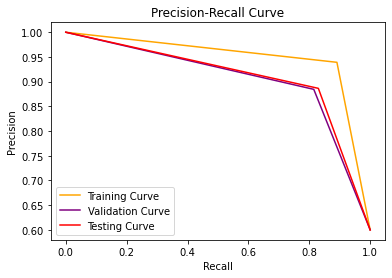

In [32]:
#create precision recall curve
fig, ax = plt.subplots()

trainLabels,trainResults=getTargetsAndPredictions(trainLocation)
precision, recall, thresholds = precision_recall_curve(trainLabels, trainResults)
ax.plot(recall, precision, color='orange',label="Training Curve")

validationLabels,validationResults=getTargetsAndPredictions(validationLocation)
precision,recall,thresholds=precision_recall_curve(validationLabels,validationResults)
ax.plot(recall,precision,color="purple",label="Validation Curve")

testLabels,testResults=getTargetsAndPredictions(testLocation)
precision,recall,thresholds=precision_recall_curve(testLabels,testResults)
ax.plot(recall,precision,color="red",label="Testing Curve")

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend()


#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend()

#display plot
plt.show()

F1 Score on Training Set : 0.9143097466091894


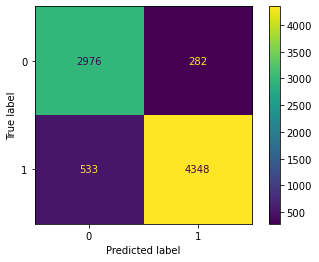

In [35]:
trainMatrix=ConfusionMatrixDisplay(confusion_matrix(trainLabels,trainResults))
trainMatrix.plot()
print(f"F1 Score on Training Set : {f1_score(trainLabels,trainResults)}")
plt.show()

F1 Score on Validation Set : 0.8481228668941979


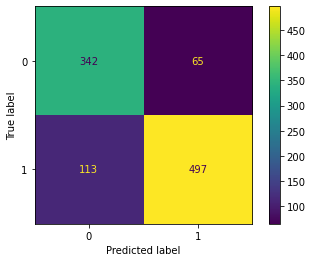

In [36]:
validationMatrix=ConfusionMatrixDisplay(confusion_matrix(validationLabels,validationResults))
validationMatrix.plot()
print(f"F1 Score on Validation Set : {f1_score(validationLabels,validationResults)}")
plt.show()

In [39]:
print(classification_report(testLabels,testResults,target_names=["No Tumor","Tumor Detected"]))

                precision    recall  f1-score   support

      No Tumor       0.77      0.84      0.80       408
Tumor Detected       0.89      0.83      0.86       611

      accuracy                           0.83      1019
     macro avg       0.83      0.84      0.83      1019
  weighted avg       0.84      0.83      0.84      1019



F1 Score on test Set : 0.8571428571428571


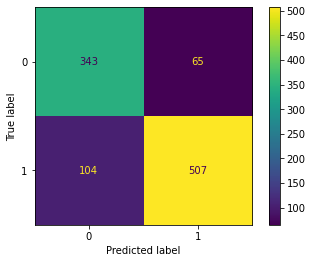

In [40]:
testMatrix=ConfusionMatrixDisplay(confusion_matrix(testLabels,testResults))
testMatrix.plot()
print(f"F1 Score on test Set : {f1_score(testLabels,testResults)}")
plt.show()